The noiseless PC emu keeps giving off errors, I want to see if I can figure out why. 

In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [32]:
import numpy as np
from GPy.models import GPKroneckerGaussianRegression
from GPy.kern import *
from itertools import izip
import h5py
from scipy.linalg import inv

In [35]:
training_pc = np.load('../bin/emu/training_pc.npy')
training_cov = np.load('../bin/emu/training_cov.npy')
#training_err = np.sqrt(np.diag(training_cov))

test_pc = np.load('../bin/emu/test_pc.npy')
test_cov = np.load('../bin/emu/test_cov.npy')


In [36]:
training_pc.shape

(200, 40)

In [37]:
thresholds = np.linspace(-0.01, 0.04, 41)
nu = ((thresholds[1:] + thresholds[:-1]) / 2.0).reshape((-1, 1))

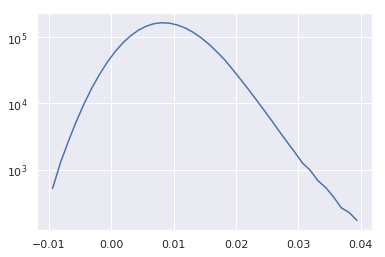

In [38]:
plt.plot(nu, training_pc[0]);
plt.yscale('log')

In [39]:
cov = test_cov[0]

In [40]:
inv(cov+np.diag(np.ones(cov.shape[0]))*1e-12)

array([[  4.61468082e-06,  -5.72861098e-08,   5.16682296e-08, ...,
          4.79621208e-07,   8.87168119e-07,  -3.26135150e-07],
       [ -5.72861098e-08,   1.89975199e-06,  -5.86193653e-08, ...,
         -2.80635386e-07,  -4.93134263e-07,   8.19503520e-07],
       [  5.16682296e-08,  -5.86193653e-08,   8.02235325e-07, ...,
         -3.92734093e-07,   1.03837405e-07,   1.55029626e-07],
       ..., 
       [  4.79621208e-07,  -2.80635386e-07,  -3.92734093e-07, ...,
          1.00314639e-04,   1.87782602e-06,   1.58264238e-06],
       [  8.87168119e-07,  -4.93134263e-07,   1.03837405e-07, ...,
          1.87782602e-06,   1.31034441e-04,   1.38928341e-06],
       [ -3.26135150e-07,   8.19503520e-07,   1.55029626e-07, ...,
          1.58264238e-06,   1.38928341e-06,   1.92557379e-04]])

In [41]:
training_pc[training_pc==0]=1e-3
np.log10(training_pc[0])

array([ 2.71424695,  3.09926276,  3.41866949,  3.71667303,  3.98522127,
        4.22731526,  4.43715333,  4.62355556,  4.78215842,  4.91622317,
        5.02447807,  5.10920761,  5.16984309,  5.20853591,  5.22225872,
        5.21544988,  5.18781134,  5.1428489 ,  5.07880353,  4.99783116,
        4.90081876,  4.78829497,  4.66792544,  4.52598009,  4.37849884,
        4.22856827,  4.07267644,  3.91410799,  3.75370597,  3.58532144,
        3.42586819,  3.26731661,  3.10223885,  2.99024016,  2.83108733,
        2.72850408,  2.58497303,  2.41989458,  2.34919356,  2.22981768])

In [42]:
fill_val = 1e-3
training_pc[training_pc==0.0]=fill_val# make loggable
test_pc[test_pc==0.0]=fill_val

training_filename = '/home/users/swmclau2/oak/Uatu/UatuFastPMTraining/UatuFastPMTraining.hdf5'
test_filename = '/home/users/swmclau2/oak/Uatu/UatuFastPMTest/UatuFastPMTest.hdf5'

train_cosmos = np.zeros((training_pc.shape[0], 2))
test_cosmos = np.zeros((test_pc.shape[0], 2))

with h5py.File(training_filename, 'r') as f:
    for i, key in enumerate(f.keys()):
        train_cosmos[i] = f[key]['Y'][0].squeeze()

with h5py.File(test_filename, 'r') as f:
    for i, key in enumerate(f.keys()):
        test_cosmos[i] = f[key]['Y'][0].squeeze()


In [43]:
mean_cosmo = test_cosmos.mean(axis=0)

#test_idx = np.argmin(np.sum((test_cosmos-mean_cosmo)**2, axis=1), axis = 0)
test_idx = int(23)
y = test_pc[test_idx]
cov = test_cov[test_idx]
cov+=np.diag(np.ones(cov.shape[0]))*1e-2 # stablize 

In [44]:
# set prior bounds
global MIN_OM, MIN_S8, MAX_S8, MAX_OM
MIN_OM, MIN_S8 = train_cosmos.min(axis=0)
MAX_OM, MAX_S8 = train_cosmos.max(axis=0)

In [45]:
thresholds = np.linspace(-0.01, 0.04, 41)
nu = ((thresholds[1:] + thresholds[:-1]) / 2.0).reshape((-1, 1))

kern1 = RBF(2, ARD=True)+Bias(2)
kern2 = RBF(1, ARD=True)+Bias(1)

In [46]:
#global emu
emu = GPKroneckerGaussianRegression(train_cosmos, nu, np.log10(training_pc), kern1,
                                   kern2)  # , Yerr=np.log10(training_err))
emu.optimize_restarts(num_restarts=3, verbose = True);

Optimization restart 1/3, f = -19043.9018678
Optimization restart 2/3, f = -12848.0403657
Optimization restart 3/3, f = -12848.0403671


In [48]:
def lnlike(theta, nu, y, inv_cov):
    """
    :param theta:
        Proposed parameters.
    :param param_names:
        The names of the parameters in theta
    :param fixed_params:
        Dictionary of parameters necessary to predict y_bar but are not being sampled over.
    :param r_bin_centers:
        The centers of the r bins y is measured in, angular or radial.
    :param ys:
        The measured values of the observables to compare to the emulators. Must be an interable that contains
        predictions of each observable.
    :param combined_inv_cov:
        The inverse covariance matrices. Explicitly, the inverse of the sum of the mesurement covaraince matrix
        and the matrix from the emulator, both for each observable. Both are independent of emulator parameters,
         so can be precomputed. Must be an iterable with a matrixfor each observable.
    :return:
        The log liklihood of theta given the measurements and the emulator.
    """

    emu_pred = 10 ** emu.predict(theta.reshape((1,-1)),nu, mean_only=True)[0].squeeze()
    delta = emu_pred - y
    chi2 = -np.dot(delta, np.dot(inv_cov, delta))
    return -np.dot(delta, np.dot(inv_cov, delta))


In [49]:
lnlike(np.array([0.3, 0.8]), nu, y, inv(cov))

-16.356166807625211

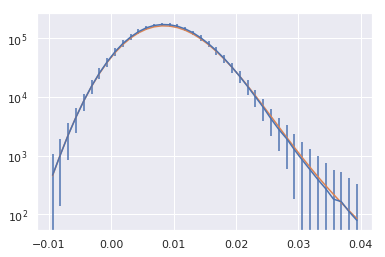

In [56]:
plt.errorbar(nu, y, yerr = np.sqrt(np.diag(cov)))
theta = np.array([0.3, 0.8])
emu_pred = 10 ** emu.predict(theta.reshape((1,-1)),nu, mean_only=True)[0].squeeze()

plt.plot(nu, emu_pred)
plt.yscale('log')

In [51]:
print np.diag(cov)

[  3.70984328e+05   8.01311798e+05   1.99230546e+06   4.24003395e+06
   8.04111389e+06   1.67160223e+07   2.96817408e+07   4.88713201e+07
   7.35153893e+07   1.05893560e+08   1.30937297e+08   1.59219137e+08
   1.60591389e+08   1.48006766e+08   1.50939712e+08   1.34954118e+08
   1.27964139e+08   1.29116234e+08   1.17349258e+08   1.04979274e+08
   9.50443468e+07   7.19141069e+07   5.68237720e+07   4.26711691e+07
   2.68575410e+07   1.68176584e+07   1.08011585e+07   7.34426618e+06
   4.42229621e+06   2.57973022e+06   1.81672264e+06   1.16281768e+06
   7.72942095e+05   5.21984471e+05   3.42916260e+05   2.14431584e+05
   1.56096297e+05   1.37386539e+05   9.24169984e+04   6.19530106e+04]
